In [55]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # Gets rid of the copy warning

# Create the dataframe
df = pd.read_csv('data/FastFurious_data.csv', skiprows=1)  # Change file to read in here
df_display = df.copy()


### Data Cleaning and Feature Engineering

In [56]:
# Turn all numeric columns from formatted strings into floats
df['Adjusted Revenue'] = df['Adjusted Revenue'].apply(lambda x:  1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['US Box Office'] = df['US Box Office'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['International Revenue'] = df['International Revenue'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','').strip(' (est.)')))
df['Average Rating'] = df['Average Rating'].apply(lambda x: float(x.replace('%', '')))
df['Metacritic'] = df['Metacritic'].apply(lambda x: float(x.replace('%', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: float(x.replace(' / 10', '').replace(' (est.)', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: x*10)

In [57]:
# Fill in 'No Data' entries with mean for column
for index, row in df.iterrows():
    if df['Adjusted Revenue'][index] == 1:
        df['Adjusted Revenue'][index] = df['Adjusted Revenue'].mean()
    if df['US Box Office'][index] == 1:
        df['US Box Office'][index] = df['US Box Office'].mean()
    if df['International Revenue'][index] == 1:
        df['International Revenue'][index] = df['International Revenue'].mean()

In [58]:
# Use qcut() to put adjusted revenue and Average Rating into 3 groups 
df['Revenue Category'] = pd.qcut(df['Adjusted Revenue'], q=3, labels=False)
df['Rating Category'] = pd.qcut(df['Average Rating'], q=3, labels=False)

# Add Changes to df_display (the formatted for viewing dataframe)
df_display[[ 'Revenue Category', 'Rating Category']] = df[['Revenue Category', 'Rating Category']]

# Change qcut numbers to qualatative categories in df_display
bin = {
    0: 'Low',
    1: 'Average',
    2: 'High'
}
df_display['Rating Category'] = df_display['Rating Category'].map(bin)  # Both map() and apply() do the same thing with different syntax
df_display['Revenue Category'] = df_display['Revenue Category'].apply(lambda x: 'Low' if x == 0 else ('Average' if x == 1 else 'High'))

### New Column Explanation
* Revenue Category classifes a movies earnings as high, average or low
* Rating Categoy classifies movie ratings as high, average or low
* These new columns will be predicted to test accuracy

In [59]:
df_display

,Title,Year,Actor,US Box Office,International Revenue,Adjusted Revenue,Average Rating,IMDb Rating,Metacritic,Revenue Category,Rating Category
0,The Fast and the Furious,2001,Vin Diesel,"$144,533,925","$207,305,509","$317,688,962",63.0%,6.8 / 10,58%,Low,Average
1,2 Fast 2 Furious,2003,Paul Walker,"$127,154,901","$236,350,661","$348,617,225",48.5%,5.9 / 10,38%,Low,Low
2,The Fast and the Furious: Tokyo Drift,2006,Lucas Black,"$62,514,415","$158,964,610","$214,002,952",52.5%,6.0 / 10,45%,Low,Low
3,Fast & Furious,2009,Vin Diesel,"$155,064,265","$360,366,870","$455,960,692",56.0%,6.6 / 10,46%,Average,Low
4,Fast Five,2011,Vin Diesel,"$209,837,675","$626,137,675","$755,596,999",69.5%,7.3 / 10,66%,Average,High
5,Fast & Furious 6,2013,Vin Diesel,"$238,679,850","$788,680,968","$918,661,007",65.5%,7.0 / 10,61%,High,High
6,Furious 7,2015,Vin Diesel,"$353,007,020","$1,515,255,622","$1,735,191,459",69.0%,7.1 / 10,67%,High,High
7,The Fate of the Furious,2017,Vin Diesel,"$226,008,385","$1,236,005,118","$1,368,632,350",61.0%,6.6 / 10,56%,High,Average
8,Fast & Furious Presents: Hobbs & Shaw,2019,Dwayne Johnson,"$173,956,935","$759,056,935","$805,663,090",62.0%,6.4 / 10,60%,Average,Average
9,F9,2021,Vin Diesel,No Data,"$163,005,000","$163,005,000",54.0%,5.5 / 10,53%,Low,Low


### Display graphs of data to be predicted

The franchines has seen revenue increase over time


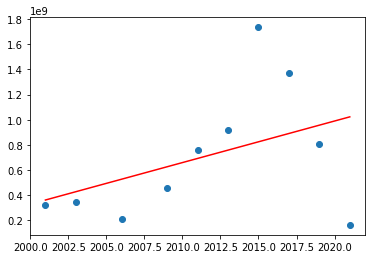

In [60]:
# Create the Revenue Plot
x = df['Year'].tolist()
y = df['Adjusted Revenue'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen revenue increase over time')
elif z[0] < -0.05:
    print('The franchise has seen revenue decrease over time')
else:
    print('The franchise has maintained a consistent revenue over time')
plt.show()

The franchines has seen review scores improve over time


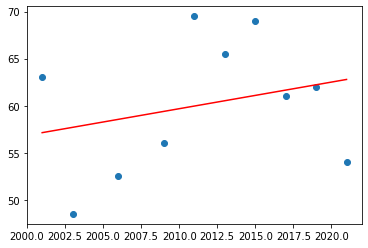

In [61]:
# Create the Average Review Score Plot
x = df['Year'].tolist()
y = df['Average Rating'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen review scores improve over time')
elif z[0] < -0.05:
    print('The franchise has seen review scores decline over time')
else:
    print('The franchise has maintained a consistent quality over time')
plt.show()

### Test Prediction Models Against Revenue Category

In [62]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rev = df.copy()
df_rev = pd.get_dummies(df_rev, columns=['Rating Category'], prefix = ['Rating'])
df_rev = df_rev.drop(['Title', 'Actor'], axis=1)

In [63]:
# Set X and Y for the training set
y = df_rev['Revenue Category']
df_rev = df_rev.drop(['Revenue Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(df_rev)

# Set the X for the training set
X = data_scaled

# Build the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [64]:
# Create the KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y_pred = knn.predict(X_test)

# Print the Accuracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 66.67%


In [65]:
# Create a DTC model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

# Make the Prediction for 'Revenue Category'
y_pred2 = clf.predict(X_test)

# Print the results
score = accuracy_score(y_test, y_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 66.67%


In [66]:
# Predict Revenue for Hypothetical Next Movie

### Test Prediction Models Against Ratings Category

In [67]:
# Use 1-hot encoding for the categorical features created by qcut()
df_rate = df.copy()
df_rate = pd.get_dummies(df_rate, columns=['Revenue Category'], prefix = ['Revenue'])
df_rate = df_rate.drop(['Title', 'Actor'], axis=1)

In [68]:
# Set Y for the training set
y2 = df_rate['Rating Category']
df_rate = df_rate.drop(['Rating Category'], axis=1)

# Scale the data
from sklearn.preprocessing import StandardScaler
std_scaler2 = StandardScaler()
data_scaled2 = std_scaler2.fit_transform(df_rate)

# Set the X for the training set
X2 = data_scaled2

# Build the training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=1)

In [69]:
# Create the KNN model
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X2_train, y2_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y2_pred = knn2.predict(X2_test)

# Print the Accuracy score
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using KNN: '+ score)

Accuracy of Revenue Category Prediction using KNN: 66.67%


In [70]:
# Create a DTC model
clf2 = DecisionTreeClassifier(random_state=1)
clf2.fit(X2_train, y2_train)

# Make the Prediction for 'Revenue Category'
y2_pred2 = clf2.predict(X2_test)

# Print the results
score = accuracy_score(y2_test, y2_pred) * 100
score = "{:,.2f}%".format(score)
print('Accuracy of Revenue Category Prediction using DTC: '+ score)

Accuracy of Revenue Category Prediction using DTC: 66.67%


In [71]:
# Predict the Rating Category of a Hypothetical Next Movie

### Conclusion

In [72]:
# Show the predicted Revenue and Rating of the Hypothetical Next Film